
# Lab02: Compressed DenseNet for Crowd Counting

> Dataset structure:
> ```
> <DATA_ROOT>/
> ├── Lab02_CDenseNet.ipynb
> ├── CDenseNet.py
> └── data/
>     ├── video/vidf/vidf1_33_ZZZ.y/*.png  # e.g., vidf1_33_ZZZ_fFFF.png ...
>     └── gt/vidf/*.mat    # e.g., vidf1_33_ZZZ_count_2K_roi*.mat ...
> ```

## 0. Mount Google Drive

In [1]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # You need to modify this part to the directory where your code is located, i.e., <DATA_ROOT>
# %cd "/content/drive/MyDrive/Deep Learning/Homeworks/Lab 02"

In [2]:
%cd "/home/bschen/deep_learning/Lab_02"

/home/bschen/deep_learning/Lab_02


## 1. Import Libraries

In [3]:
# %pip install torchinfo

In [4]:
# ---- import library ----
import os, re, glob, random
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
from scipy.io import loadmat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms, utils as vutils
import matplotlib.pyplot as plt

# %matplotlib inline

def set_global_seed(seed: int):
    # Python
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    print(f"[INFO] Global seed set to {seed}")

set_global_seed(69)

[INFO] Global seed set to 69


## 2. Dataset Definition

In [5]:
# File naming for vidf frames: vidf1_33_ZZZ_fFFF.png (ZZZ: 000..019, FFF: 001..200)
FNAME_RE = re.compile(r"vidf1_33_(\d{3})_f(\d{3})\.png")

# Train: 401..2900 | Val: 2901..3600 | Test: 1..400 & 3601..4000
SPLIT_RANGES = {
    "train": [(401, 2900)],   # (2500 frames)
    "val":   [(2901, 3600)],  # (700 frames)
    # "test":  [(1, 400), (3601, 4000)],   # full test set (800 frames)
    "test":  [(3601, 3800)],             # public test set (200 frames)
}

# Others
LOG_FILE = "log.csv"

In [6]:
class UCSDDataset(Dataset):
    """
    UCSD vidf frames -> (x, people_cnts) where x is grayscale image tensor,
    people_cnts is [r, l, t] crowd counts for the frame.
    """
    def __init__(self, split: str = "train", transform=None):
        super().__init__()
        assert split in ["train", "val", "test"]
        self.img_dir = './data/video/vidf'
        self.gt_dir  = './data/gt/vidf'

        # preprocess transform: to tensor + normalize to [-1,1]
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        # enumerate frames that belong to this split
        self.items: List[Tuple[int, int, str]] = []  # (clip_idx, f_in_clip, path)
        pngs = sorted(glob.glob(os.path.join(self.img_dir, "**", "*.png"), recursive=True))
        for p in pngs:
            m = FNAME_RE.match(os.path.basename(p))
            if not m:
                continue
            clip_str, f_str = m.groups()
            clip_idx = int(clip_str)           # 000..019
            f_in_clip = int(f_str)             # 001..200
            gidx = clip_idx * 200 + f_in_clip  # global indexing
            for a, b in SPLIT_RANGES[split]:
                if a <= gidx <= b:
                    self.items.append((clip_idx, f_in_clip, p))
                    break

        # cache for per-clip count .mat files
        self._count_cache: Dict[int, Dict[str, np.ndarray]] = {}

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        clip_idx, f_in_clip, img_p = self.items[idx]
        img = Image.open(img_p).convert('L')
        x = self.transform(img)
        dmap = self._load_counts_clip(clip_idx)
        k = f_in_clip - 1  # 0-based index into 200 frames
        r = dmap.get('r', None)
        l = dmap.get('l', None)
        t = dmap.get('t', None)
        if r is None or l is None or t is None:
            raise KeyError(f"[ERROR] Missing 'r','l','t' in dirs for clip {clip_idx}. Have={list(dmap.keys())}")
        people_cnts = torch.tensor([r[k], l[k], t[k]], dtype=torch.float32)
        return x, people_cnts

    def _load_counts_clip(self, clip_idx: int) -> Dict[str, np.ndarray]:
        """
        Loader for DT mat layout:
        - file:  vidf1_33_ZZZ_count_2K_roi_mainwalkway.mat
        - key:   'cgt' (1x1 struct)
        - fields: cgt.dir (['r','l','t','n']), cgt.count (cell of 4 vectors length 200)
        Returns dict {'r': vec, 'l': vec, 't': vec} as float32.
        """
        if clip_idx in self._count_cache:
            return self._count_cache[clip_idx]

        path = os.path.join(self.gt_dir, f"vidf1_33_{clip_idx:03d}_count_2K_roi_mainwalkway.mat")
        mat = loadmat(path, squeeze_me=False, struct_as_record=False)

        # 1x1 MATLAB struct at key 'cgt'
        entry = mat['cgt'].flat[0]  # get the single struct

        # Access fields
        dirs_raw   = getattr(entry, 'dir')
        counts_raw = getattr(entry, 'count')

        # Normalize to plain Python lists
        dirs_seq   = np.squeeze(dirs_raw).ravel()
        counts_seq = np.squeeze(counts_raw).ravel()

        # Convert names to strings and counts to float arrays
        dirs_list   = [str(np.squeeze(d).item()) for d in dirs_seq]
        counts_list = [np.squeeze(c).astype(np.float32) for c in counts_seq]  # (200,) each

        # Build the map; ignore 'n' (no motion)
        dmap = {}
        for name, vec in zip(dirs_list, counts_list):
            k = name.strip().lower()
            if   k == 'r': dmap['r'] = vec
            elif k == 'l': dmap['l'] = vec
            elif k == 't': dmap['t'] = vec

        missing = [nm for nm in ('r','l','t') if nm not in dmap]
        if missing:
            raise KeyError(f"[ERROR] Missing {missing} in GT for clip {clip_idx}. dirs={dirs_list}")

        # Cache & return
        self._count_cache[clip_idx] = dmap
        return dmap

In [7]:
# Create dataset instances
train_ds = UCSDDataset(split="train")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle= True, pin_memory=True)

print(f"[INFO] Dataset sizes: train={len(train_ds)}")

for i in range(1):
    x, y = next(iter(train_loader))
    print(f"x.shape={x.shape}, y.shape={y.shape}, y={y}")
    # vutils.save_image((x+1)/2, f"sample_batch_{i}.png", nrow=4)
    print(f"[INFO] Sample batch image saved to sample_batch_{i}.png")

[INFO] Dataset sizes: train=2500
x.shape=torch.Size([8, 1, 158, 238]), y.shape=torch.Size([8, 3]), y=tensor([[29., 10., 39.],
        [ 7., 13., 20.],
        [13.,  8., 21.],
        [13., 17., 30.],
        [ 9., 15., 24.],
        [28., 10., 38.],
        [18.,  8., 26.],
        [ 9., 15., 24.]])
[INFO] Sample batch image saved to sample_batch_0.png


## 3. Visualize Sample Frames & Labels

Labels [r, l, t] for shown samples:
  #00 -> [8.0, 11.0, 19.0]
  #01 -> [4.0, 8.0, 12.0]
  #02 -> [18.0, 7.0, 25.0]
  #03 -> [7.0, 11.0, 18.0]


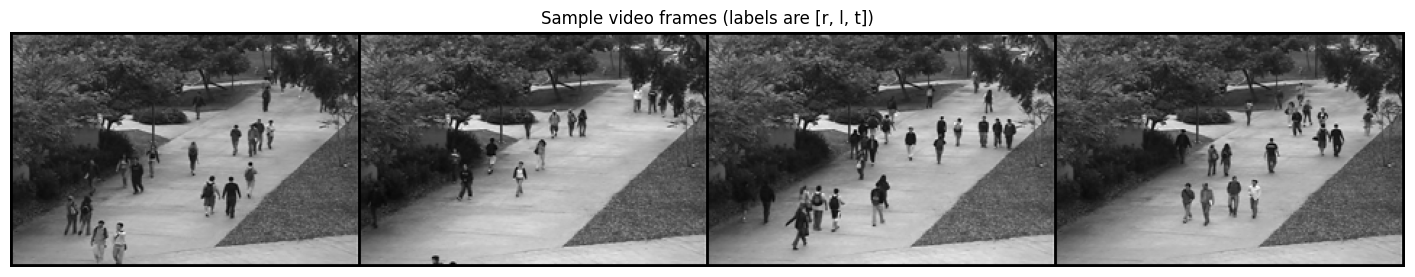

In [8]:
def visualize_samples(dataset: UCSDDataset, n: int = 4):
    """ Show a grid of n sample images and print their [r,l,t] labels. """
    if len(dataset) == 0:
        print("[WARN] Dataset is empty. Please check DATA_ROOT.")
        return

    idxs = [random.randrange(len(dataset)) for _ in range(min(n, len(dataset)))]
    xs, ys = [], []
    for idx in idxs:
        x, people_cnts = dataset[idx]
        xs.append(x)
        ys.append(people_cnts.numpy())

    cols = min(8, len(xs))
    rows = int(np.ceil(len(xs) / cols))
    grid = vutils.make_grid(xs, nrow=cols, normalize=True, scale_each=True)

    plt.figure(figsize=(4.5*cols, 3.8*rows))  # Same scaling as lower function
    plt.axis('off')
    plt.title("Sample video frames (labels are [r, l, t])")
    plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap='gray')

    print("Labels [r, l, t] for shown samples:")
    for i, people_cnts in enumerate(ys):
        print(f"  #{i:02d} -> {[float(f'{v:.2f}') for v in people_cnts.tolist()]}")

try:
    _tmp_ds = UCSDDataset(split="train")
    visualize_samples(_tmp_ds, n=4)
except Exception as e:
    print("[WARN] Visualization skipped:", e)

## 4. Import Model

In [9]:
from CDenseNet import LDB, CDenseNet

model = CDenseNet()
print(f"[INFO] Model created: {model.__class__.__name__}")

Initializing CDenseNet with 16 LDBs, growth rate t=0.5, input channels=1, output dim=3
Building LDB 01/16
Building LDB 02/16
Building LDB 03/16
Building LDB 04/16
Building LDB 05/16
Building LDB 06/16
Building LDB 07/16
Building LDB 08/16
Building LDB 09/16
Building LDB 10/16
Building LDB 11/16
Building LDB 12/16
Building LDB 13/16
Building LDB 14/16
Building LDB 15/16
Building LDB 16/16
CDenseNet initialization complete.
[INFO] Model created: CDenseNet


In [10]:
model_summary = summary(
    model,
    input_size = (1, 1, 158, 238),
    device = "cuda",
    depth = 9999,  # Large int value to show full depth
    col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    row_settings = ["var_names"]
)

print(model_summary)

with open("summary.txt", "w") as f:
    f.write(str(model_summary))

print("[INFO] Summary displayed above and saved to summary.txt")

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CDenseNet (CDenseNet)                    [1, 1, 158, 238]          [1, 3]                    --                        --                        --
├─Sequential (enc)                       [1, 1, 158, 238]          [1, 32, 158, 238]         --                        --                        --
│    └─Conv2d (0)                        [1, 1, 158, 238]          [1, 32, 158, 238]         320                       [3, 3]                    12,033,280
│    └─BatchNorm2d (1)                   [1, 32, 158, 238]         [1, 32, 158, 238]         64                        --                        64
│    └─ReLU (2)                          [1, 32, 158, 238]         [1, 32, 158, 238]         --                        --                        --
├─ModuleList (ldb_layers)                --                        --                        --  

## 5. Create DataLoaders

In [11]:
batch_size = 8

# Create dataset instances
train_ds = UCSDDataset(split="train")
val_ds   = UCSDDataset(split="val")
test_ds  = UCSDDataset(split="test")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle= True, pin_memory=True)
val_loader   = DataLoader(  val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader( test_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"[INFO] Dataset sizes: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

[INFO] Dataset sizes: train=2500, val=700, test=200


## 6. Training Setup

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)

# you can try 10~15 at first
num_epochs = 30
# Learning rate
lr = 1e-2

# Loss function
criterion = nn.SmoothL1Loss()
# criterion = nn.L1Loss()
# criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)
# scheduler = None

[INFO] Using device: cuda


## 7. Training Loop

In [13]:
from tqdm.auto import tqdm

# Initialization
model = model.to(device)
ckpt_path = "model.pth"
mae_best = float('inf')

# Write log
with open(LOG_FILE, "w") as f:
    f.write("epoch, train_loss, val_loss, mae_r, mae_l, mae_t, rmse_r, rmse_l, rmse_t, avg_mae, avg_rmse\n")

# Training loop
for epoch in range(1, num_epochs + 1):
    # ------------------------------ Training phase ------------------------------ #
    model.train()  # Set the model to training mode
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs} [Train]', leave=False, position=0, smoothing=0.1)
    for in_img, people_cnts in train_bar:
        in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)

        #################################################
        # Please finish the "Training phase" code here.

        # Forward pass & compute loss
        outputs = model(in_img)
        loss = criterion(outputs, people_cnts)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        #################################################

        running_loss += loss.item() * people_cnts.size(0)
        train_bar.set_postfix(loss=f'{loss.item():.4f}')

    # ------------------------------ Validation phase ------------------------------ #
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    # Per-component MAE/RMSE accumulators for [r, l, t]
    abs_sum = torch.zeros(3, dtype=torch.float64)
    sqr_sum = torch.zeros(3, dtype=torch.float64)

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch}/{num_epochs} [Val]', leave=False, position=0, smoothing=0.1)
        for in_img, people_cnts in val_bar:
            in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)

            ###################################################
            # Please finish the "Validation phase" code here.

            # Forward pass & compute loss
            outputs = model(in_img)
            loss = criterion(outputs, people_cnts)
            val_loss += loss.item() * people_cnts.size(0)

            ###################################################

            # Calculate metrics for validation results
            err = outputs - people_cnts
            abs_sum += err.abs().sum(dim=0).double().cpu()
            sqr_sum += (err ** 2).sum(dim=0).double().cpu()
            val_bar.set_postfix(loss=f'{loss.item():.4f}')

    epoch_loss = running_loss / len(train_ds)
    avg_val_loss = val_loss / len(val_ds)
    mae = (abs_sum / len(val_ds)).tolist()
    avg_mae = sum(mae) / 3.0
    rmse = torch.sqrt(sqr_sum / len(val_ds)).tolist()
    avg_rmse = sum(rmse) / 3.0
    if scheduler:
        scheduler.step(avg_mae)

    # if avg_mae < mae_best:
    if avg_mae < mae_best + 0.1:
        mae_best = avg_mae if avg_mae < mae_best else mae_best
        print("model saved")
        torch.save(model.state_dict(), ckpt_path)

    print(
        f"[Epoch {epoch:2d}] "
        f"Train Loss: {epoch_loss:8.4f} | "
        f" MAE[r,l,t] = [{mae[0]:7.4f}, {mae[1]:7.4f}, {mae[2]:7.4f}] | "
        f"Avg MAE: {avg_mae:7.4f}"
    )
    print(
        f"           "
        f"  Val Loss: {avg_val_loss:8.4f} | "
        f"RMSE[r,l,t] = [{rmse[0]:7.4f}, {rmse[1]:7.4f}, {rmse[2]:7.4f}] | "
        f"Avg RMSE: {avg_rmse:7.4f}"
    )

    # Log epoch results
    with open(LOG_FILE, "a") as f:
        f.write(
            f"{epoch}, {epoch_loss:.4f}, {avg_val_loss:.4f}, "
            f"{mae[0]:.4f}, {mae[1]:.4f}, {mae[2]:.4f}, "
            f"{rmse[0]:.4f}, {rmse[1]:.4f}, {rmse[2]:.4f}, "
            f"{avg_mae:.4f}, {avg_rmse:.4f}\n"
        )

/home/bschen/anaconda3/envs/general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bschen/anaconda3/envs/general/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


model saved
[Epoch  1] Train Loss:   5.4826 |  MAE[r,l,t] = [ 1.9055,  3.3355,  2.1112] | Avg MAE:  2.4507
             Val Loss:   2.0025 | RMSE[r,l,t] = [ 2.4001,  4.0941,  2.6416] | Avg RMSE:  3.0453


[Epoch  2] Train Loss:   2.8811 |  MAE[r,l,t] = [ 8.4519,  5.2548, 14.4272] | Avg MAE:  9.3780
             Val Loss:   8.8857 | RMSE[r,l,t] = [ 8.8999,  6.0872, 14.9235] | Avg RMSE:  9.9702


[Epoch  3] Train Loss:   2.6106 |  MAE[r,l,t] = [ 2.1387,  4.8077,  5.5757] | Avg MAE:  4.1740
             Val Loss:   3.6883 | RMSE[r,l,t] = [ 2.5247,  5.6224,  6.0640] | Avg RMSE:  4.7370


[Epoch  4] Train Loss:   2.1567 |  MAE[r,l,t] = [ 3.3510,  3.2755,  5.6231] | Avg MAE:  4.0832
             Val Loss:   3.6060 | RMSE[r,l,t] = [ 3.9317,  4.0308,  6.1994] | Avg RMSE:  4.7206


[Epoch  5] Train Loss:   2.0243 |  MAE[r,l,t] = [ 1.7394,  4.4678,  5.0810] | Avg MAE:  3.7627
             Val Loss:   3.2866 | RMSE[r,l,t] = [ 2.1381,  5.2957,  5.7574] | Avg RMSE:  4.3971


[Epoch  6] Train Loss:   1.8481 |  MAE[r,l,t] = [ 5.6386,  3.2459,  8.2844] | Avg MAE:  5.7230
             Val Loss:   5.2343 | RMSE[r,l,t] = [ 6.1305,  3.9867,  8.6990] | Avg RMSE:  6.2721


[Epoch  7] Train Loss:   1.6722 |  MAE[r,l,t] = [ 5.5569,  3.3699,  4.5337] | Avg MAE:  4.4868
             Val Loss:   4.0066 | RMSE[r,l,t] = [ 6.3626,  4.0487,  5.1702] | Avg RMSE:  5.1939


[Epoch  8] Train Loss:   1.5258 |  MAE[r,l,t] = [ 3.1828,  6.0281,  3.5914] | Avg MAE:  4.2675
             Val Loss:   3.7872 | RMSE[r,l,t] = [ 3.8602,  6.8609,  4.4207] | Avg RMSE:  5.0473


[Epoch  9] Train Loss:   1.4036 |  MAE[r,l,t] = [ 1.8785,  5.3634,  5.3382] | Avg MAE:  4.1934
             Val Loss:   3.7193 | RMSE[r,l,t] = [ 2.3265,  6.1989,  6.0668] | Avg RMSE:  4.8641


[Epoch 10] Train Loss:   1.3737 |  MAE[r,l,t] = [ 2.0943,  5.5534,  7.0718] | Avg MAE:  4.9065
             Val Loss:   4.4265 | RMSE[r,l,t] = [ 2.5490,  6.5104,  7.6445] | Avg RMSE:  5.5680


[Epoch 11] Train Loss:   1.3428 |  MAE[r,l,t] = [ 4.5969,  3.1203,  5.7008] | Avg MAE:  4.4727
             Val Loss:   3.9987 | RMSE[r,l,t] = [ 5.6089,  3.7325,  6.3371] | Avg RMSE:  5.2262


[Epoch 12] Train Loss:   1.2546 |  MAE[r,l,t] = [ 2.7675,  3.0078,  2.3961] | Avg MAE:  2.7238
             Val Loss:   2.2636 | RMSE[r,l,t] = [ 3.3358,  3.6746,  3.0029] | Avg RMSE:  3.3378


[Epoch 13] Train Loss:   1.3053 |  MAE[r,l,t] = [ 2.5025,  3.2224,  4.9095] | Avg MAE:  3.5448
             Val Loss:   3.0752 | RMSE[r,l,t] = [ 3.0412,  4.0367,  5.5168] | Avg RMSE:  4.1982


[Epoch 14] Train Loss:   1.1708 |  MAE[r,l,t] = [ 2.0119,  3.2647,  3.3253] | Avg MAE:  2.8673
             Val Loss:   2.3943 | RMSE[r,l,t] = [ 2.3433,  3.8626,  3.8848] | Avg RMSE:  3.3636


[Epoch 15] Train Loss:   1.1121 |  MAE[r,l,t] = [ 2.3014,  2.9628,  2.4074] | Avg MAE:  2.5572
             Val Loss:   2.0925 | RMSE[r,l,t] = [ 2.9550,  3.5975,  2.9241] | Avg RMSE:  3.1589


model saved
[Epoch 16] Train Loss:   1.1081 |  MAE[r,l,t] = [ 1.8600,  2.9866,  2.4747] | Avg MAE:  2.4404
             Val Loss:   1.9868 | RMSE[r,l,t] = [ 2.2058,  3.7834,  3.1098] | Avg RMSE:  3.0330


model saved
[Epoch 17] Train Loss:   1.0518 |  MAE[r,l,t] = [ 1.6921,  2.6966,  1.9051] | Avg MAE:  2.0979
             Val Loss:   1.6515 | RMSE[r,l,t] = [ 2.0142,  3.2826,  2.3914] | Avg RMSE:  2.5628


[Epoch 18] Train Loss:   0.9670 |  MAE[r,l,t] = [ 1.8142,  3.2300,  3.2902] | Avg MAE:  2.7782
             Val Loss:   2.3206 | RMSE[r,l,t] = [ 2.1846,  4.0292,  3.9535] | Avg RMSE:  3.3891


[Epoch 19] Train Loss:   0.9168 |  MAE[r,l,t] = [15.5733,  3.6891, 12.8064] | Avg MAE: 10.6896
             Val Loss:  10.2003 | RMSE[r,l,t] = [16.1380,  4.4471, 13.2056] | Avg RMSE: 11.2635


[Epoch 20] Train Loss:   0.8314 |  MAE[r,l,t] = [ 1.9244,  5.3446,  4.3044] | Avg MAE:  3.8578
             Val Loss:   3.3879 | RMSE[r,l,t] = [ 2.3206,  6.1210,  4.8674] | Avg RMSE:  4.4364


model saved
[Epoch 21] Train Loss:   0.7637 |  MAE[r,l,t] = [ 1.7784,  2.6873,  2.0294] | Avg MAE:  2.1650
             Val Loss:   1.7101 | RMSE[r,l,t] = [ 2.0755,  3.3064,  2.5327] | Avg RMSE:  2.6382


[Epoch 22] Train Loss:   0.7960 |  MAE[r,l,t] = [ 2.6122,  3.4691,  2.0361] | Avg MAE:  2.7058
             Val Loss:   2.2434 | RMSE[r,l,t] = [ 3.1834,  4.1851,  2.5811] | Avg RMSE:  3.3166


model saved
[Epoch 23] Train Loss:   0.6456 |  MAE[r,l,t] = [ 1.9046,  2.6054,  1.9922] | Avg MAE:  2.1674
             Val Loss:   1.7140 | RMSE[r,l,t] = [ 2.2067,  3.1500,  2.4393] | Avg RMSE:  2.5987


[Epoch 24] Train Loss:   0.6407 |  MAE[r,l,t] = [ 2.6837,  5.3296,  2.9633] | Avg MAE:  3.6589
             Val Loss:   3.1913 | RMSE[r,l,t] = [ 3.3316,  6.2448,  3.7666] | Avg RMSE:  4.4477


model saved
[Epoch 25] Train Loss:   0.5924 |  MAE[r,l,t] = [ 1.8682,  2.4794,  1.8739] | Avg MAE:  2.0738
             Val Loss:   1.6289 | RMSE[r,l,t] = [ 2.2249,  3.0641,  2.3403] | Avg RMSE:  2.5431


[Epoch 26] Train Loss:   0.6084 |  MAE[r,l,t] = [ 2.0092,  2.8167,  2.8467] | Avg MAE:  2.5575
             Val Loss:   2.0868 | RMSE[r,l,t] = [ 2.3762,  3.4612,  3.3244] | Avg RMSE:  3.0540


[Epoch 27] Train Loss:   0.6124 |  MAE[r,l,t] = [ 2.0771,  2.6577,  1.9343] | Avg MAE:  2.2230
             Val Loss:   1.7699 | RMSE[r,l,t] = [ 2.4878,  3.3278,  2.4069] | Avg RMSE:  2.7408


[Epoch 28] Train Loss:   0.6431 |  MAE[r,l,t] = [ 2.1544,  2.7202,  3.3731] | Avg MAE:  2.7492
             Val Loss:   2.2874 | RMSE[r,l,t] = [ 2.6666,  3.4349,  4.0473] | Avg RMSE:  3.3829


[Epoch 29] Train Loss:   0.5391 |  MAE[r,l,t] = [ 2.0193,  3.1030,  2.9364] | Avg MAE:  2.6862
             Val Loss:   2.2116 | RMSE[r,l,t] = [ 2.3501,  3.6611,  3.4391] | Avg RMSE:  3.1501


[Epoch 30] Train Loss:   0.5974 |  MAE[r,l,t] = [ 2.4850,  4.0997,  2.2961] | Avg MAE:  2.9602
             Val Loss:   2.4936 | RMSE[r,l,t] = [ 3.0791,  4.8652,  2.9716] | Avg RMSE:  3.6387


## 8. Inference on Test Set

[INFO] Loaded model state dict from checkpoint: model.pth


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

[TEST]  MAE[r,l,t] = [2.1738, 2.6810, 0.9893] | Avg  MAE = 1.9481
[TEST] RMSE[r,l,t] = [2.3617, 2.9192, 1.2176] | Avg RMSE = 2.1662


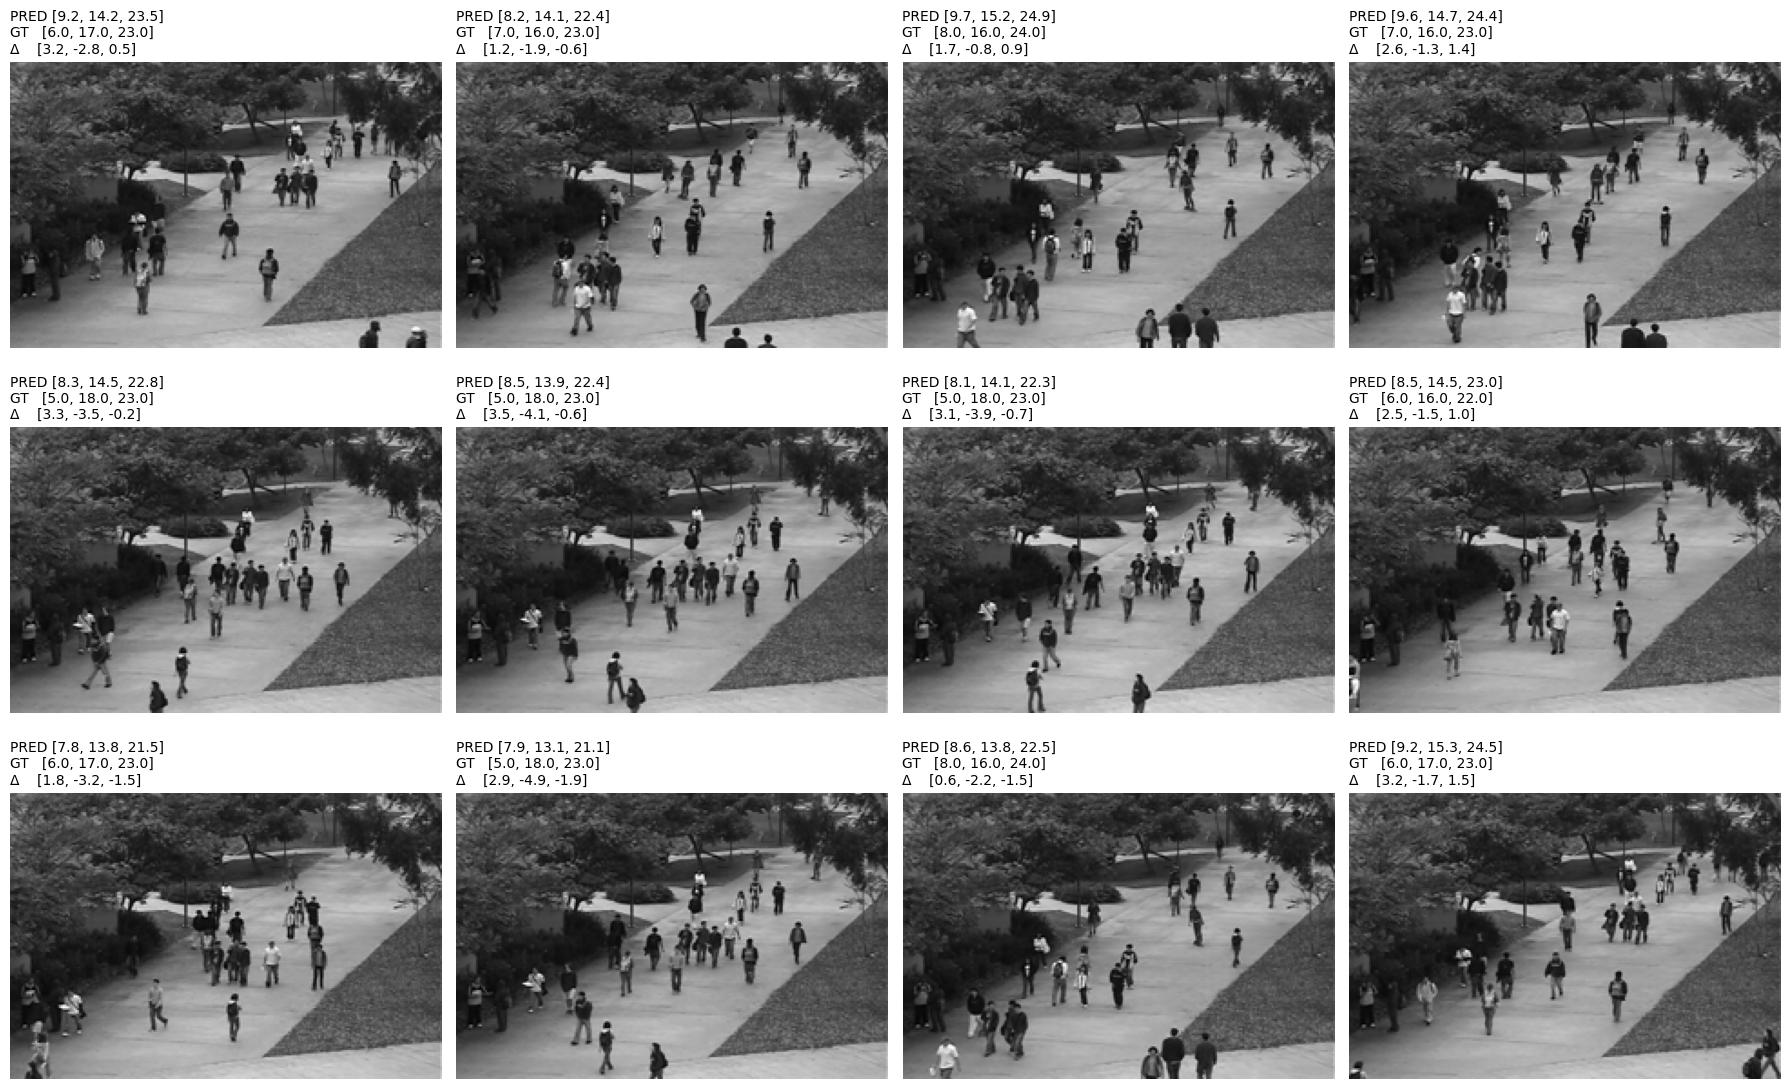

In [14]:
from tqdm.auto import tqdm

_ckpt_path = ckpt_path if 'ckpt_path' in globals() else 'model.pth'

if os.path.exists(_ckpt_path):
    try:
        # Load checkpoint
        ck = torch.load(_ckpt_path, map_location=device)
        model.load_state_dict(ck)
        print(f"[INFO] Loaded model state dict from checkpoint: {_ckpt_path}")

    except Exception as e:
        print(f"[ERROR] Error loading checkpoint {_ckpt_path}: {e}")
        print("[WARN] Evaluating current in-memory weights.")
else:
    print("[WARN] No checkpoint found; evaluating current in-memory weights.")

model.eval()
abs_sum = torch.zeros(3, dtype=torch.float64)
sqr_sum = torch.zeros(3, dtype=torch.float64)

# Image number to display after testing
num_show = 12
sampled = []
seen = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Evaluating", leave=False)
    for batch_idx, (in_img, people_cnts) in enumerate(test_bar):
        in_img = in_img.to(device, non_blocking=True)
        people_cnts = people_cnts.to(device, non_blocking=True)
        pred_cnts = model(in_img)

        err = pred_cnts - people_cnts
        abs_sum += err.abs().sum(dim=0).double().cpu()
        sqr_sum += (err**2).sum(dim=0).double().cpu()

        # Reservoir sampling: keep a random 12 from the whole stream
        B = in_img.size(0)
        for i in range(B):
            if len(sampled) < num_show:
                sampled.append((
                    in_img[i].detach().cpu(),
                    people_cnts[i].detach().cpu(),
                    pred_cnts[i].detach().cpu()
                ))
            else:
                j = random.randint(0, seen)
                if j < num_show:
                    sampled[j] = (
                        in_img[i].detach().cpu(),
                        people_cnts[i].detach().cpu(),
                        pred_cnts[i].detach().cpu()
                    )
            seen += 1

        test_bar.set_postfix({
            'MAE[r, l, t]' : [f"{(abs_sum[i]/((batch_idx + 1) * people_cnts.size(0))):.4f}" for i in range(3)],
            'RMSE[r, l, t]': [f"{(sqr_sum[i]/((batch_idx + 1) * people_cnts.size(0))).sqrt().item():.4f}" for i in range(3)],
        })

# Calculate final metrics
test_mae = (abs_sum / len(test_ds)).tolist()
test_rmse = torch.sqrt(sqr_sum / len(test_ds)).tolist()

# Print results
print(
    f"[TEST]  MAE[r,l,t] = [{test_mae[0]:.4f}, {test_mae[1]:.4f}, {test_mae[2]:.4f}] | "
    f"Avg  MAE = {(sum(test_mae)/3):.4f}"
)
print(
    f"[TEST] RMSE[r,l,t] = [{test_rmse[0]:.4f}, {test_rmse[1]:.4f}, {test_rmse[2]:.4f}] | "
    f"Avg RMSE = {(sum(test_rmse)/3):.4f}"
)

# Plotting
n = len(sampled)
cols = min(4, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 3.8*rows))
if rows == 1 and cols == 1:
    axes = np.array([[axes]])
elif rows == 1:
    axes = np.array([axes])

for idx, (img, gt, pred) in enumerate(sampled):
    ax = axes[idx // cols, idx % cols]
    img = (img * 0.5 + 0.5).clamp(0, 1).squeeze(0).numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    gt_np = gt.numpy(); pr_np = pred.numpy(); delta = pr_np - gt_np
    ax.set_title(
        f"PRED [{pr_np[0]:.1f}, {pr_np[1]:.1f}, {pr_np[2]:.1f}]\n"
        f"GT   [{gt_np[0]:.1f}, {gt_np[1]:.1f}, {gt_np[2]:.1f}]\n"
        f"Δ    [{delta[0]:.1f}, {delta[1]:.1f}, {delta[2]:.1f}]",
        fontsize=10, loc='left'
    )

for j in range(n, rows*cols):
    axes[j // cols, j % cols].axis('off')

plt.tight_layout()
plt.show()